**Author:** Ahmadreza Attarpour  
**Email:** [a.attarpour@mail.utoronto.ca](mailto:a.attarpour@mail.utoronto.ca)  

This notebook demonstrates Linear Regression (multivariable) problem with PyTorch

---

### Linear Regression (Multi-variable)


Fit the prediction function f(x) to the training data to predict continuous real value.

Let's derive the gradients of the cost function using the **chain rule**.

We define the prediction as:

$$
\hat{y}^{(i)} = \mathbf{w}^T \mathbf{x}^{(i)} + b
$$

The cost function for a single data point $(\mathbf{x}^{(i)}, y^{(i)})$ is:

$$
J^{(i)} = \frac{1}{2} \left( \hat{y}^{(i)} - y^{(i)} \right)^2
$$

To compute the gradient of $J^{(i)}$ with respect to each weight $w_j$, we apply the chain rule:

$$
\frac{\partial J^{(i)}}{\partial w_j} = \frac{\partial J^{(i)}}{\partial \hat{y}^{(i)}} \cdot \frac{\partial \hat{y}^{(i)}}{\partial w_j}
$$

We know:

$$
\frac{\partial J^{(i)}}{\partial \hat{y}^{(i)}} = \hat{y}^{(i)} - y^{(i)}
$$

and

$$
\frac{\partial \hat{y}^{(i)}}{\partial w_j} = x_j^{(i)}
$$

So putting it together:

$$
\frac{\partial J^{(i)}}{\partial w_j} = (\hat{y}^{(i)} - y^{(i)}) \cdot x_j^{(i)}
$$

To get the full gradient over the dataset of $m$ examples, we average:

$$
\frac{\partial J}{\partial w_j} = \frac{1}{m} \sum_{i=1}^m (\hat{y}^{(i)} - y^{(i)}) x_j^{(i)}
$$

---

For the bias term $b$, we use:

$$
\frac{\partial J^{(i)}}{\partial b} = \frac{\partial J^{(i)}}{\partial \hat{y}^{(i)}} \cdot \frac{\partial \hat{y}^{(i)}}{\partial b}
$$

Since:

$$
\frac{\partial \hat{y}^{(i)}}{\partial b} = 1
$$

Then:

$$
\frac{\partial J^{(i)}}{\partial b} = \hat{y}^{(i)} - y^{(i)}
$$

And the total gradient:

$$
\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (\hat{y}^{(i)} - y^{(i)})
$$

---

### Parameter updates using gradient descent:

$$
w_j := w_j - \alpha \cdot \frac{\partial J}{\partial w_j}
$$

$$
b := b - \alpha \cdot \frac{\partial J}{\partial b}
$$

Where $\alpha$ is the learning rate.

---
Python Practice
---



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.metrics import mean_absolute_error
import argparse
import time
# setting random seed for reproducibility
np.random.seed(1210)

## 1. Data preparation

Preparing data for linear regression. Data made of combining $sin(x)$ and $log(x)$ with some random error  

$$y = \ 2 sin(x_1) + log({1 \over 2}x_2^2) + e$$  
$$ e \sim \mathcal{N} (0, 0.5) $$

As shown in the equation above, $sin(x)$ and $log(x)$ has different input $x_1$ and $x_2$ to have the output $y$. Therefore, the dataset we have has two input features for one $y$ value which requires **multivariable linear regression**.

---
The function generates total 2400 data and it is split into three parts; training, validation and testing. Each dataset has 1600, 400 and 400 respectively.

**Data Set**  
$$X_{train} \in \mathcal{R}^{1600 \times 2}, Y_{train} \in \mathcal{R}^{1600}$$  
$$X_{val} \in \mathcal{R}^{400 \times 2}, Y_{val} \in \mathcal{R}^{400}$$  
$$X_{test} \in \mathcal{R}^{400 \times 2}, Y_{test} \in \mathcal{R}^{400}$$

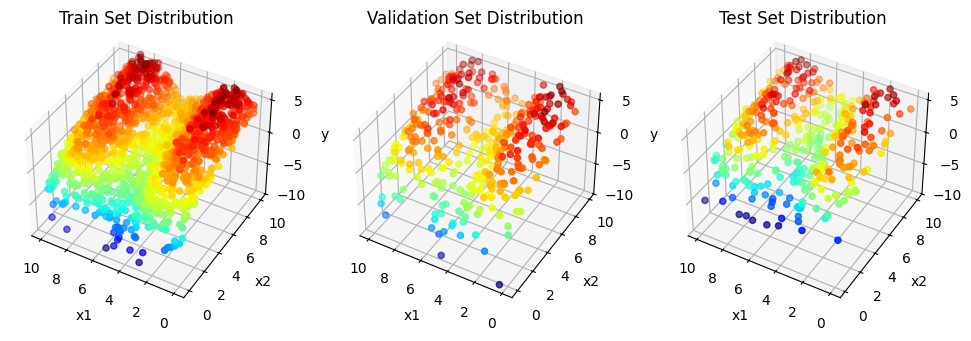

In [2]:
# ====== Data generation using Numpy ====== #
num_data = 2400
x1 = np.random.rand(num_data) * 10
x2 = np.random.rand(num_data) * 10
e = np.random.normal(0, 0.5, num_data)

X = np.array([x1, x2]).T

y = 2*np.sin(x1) + np.log(0.5*x2**2) + e

# ====== Split Dataset ====== #

train_X, train_y = X[:1600, :], y[:1600]  # 0 ~ 1599
val_X, val_y = X[1600:2000, :], y[1600:2000] # 1600 ~ 1999
test_X, test_y = X[2000:, :], y[2000:] # 2000 ~ 2399



# ====== Visualize Each Dataset ====== #
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.scatter(train_X[:, 0], train_X[:, 1], train_y, c=train_y, cmap='jet')

ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('y')
ax1.set_title('Train Set Distribution')
ax1.set_zlim(-10, 6)
ax1.view_init(40, -60)
ax1.invert_xaxis()

ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.scatter(val_X[:, 0], val_X[:, 1], val_y, c=val_y, cmap='jet')

ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('y')
ax2.set_title('Validation Set Distribution')
ax2.set_zlim(-10, 6)
ax2.view_init(40, -60)
ax2.invert_xaxis()

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.scatter(test_X[:, 0], test_X[:, 1], test_y, c=test_y, cmap='jet')

ax3.set_xlabel('x1')
ax3.set_ylabel('x2')
ax3.set_zlabel('y')
ax3.set_title('Test Set Distribution')
ax3.set_zlim(-10, 6)
ax3.view_init(40, -60)
ax3.invert_xaxis()

plt.show()

In [3]:
# print the size of x and y for train, val, test

print("Train set size: ", train_X.shape, train_y.shape)
print("Validation set size: ", val_X.shape, val_y.shape)
print("Test set size: ", test_X.shape, test_y.shape)

Train set size:  (1600, 2) (1600,)
Validation set size:  (400, 2) (400,)
Test set size:  (400, 2) (400,)


## 2. Model define  

Linear model is defined as $H(x) = Wx + b$ by calling `nn.Linear` module in PyTorch.

### **Linear Model**   
$$H = \ XW + b \ \ ( W \in \mathcal{R}^{2 \times 1}, b \in \mathcal{R}^{1}, H \in \mathcal{R}^{N \times 1})$$

In [8]:
# ====== Define the Neural Network ====== #
class LinearRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.linear = nn.Linear(input_dim, output_dim, bias=True)

    def forward(self, x):
        return self.linear(x)

## 3. Simulation Define

`pytorch` has a function named `loss.backward()` to calculate parameter gradients and then `optimizer.step()` can update all parameters using those gradient.

For every a certain amount of iteration, Test Set is tested by comparing the predicted value with true value using Mean Absolute Error. 

$$MAE(Y_{true}, Y_{predict}) = \sum_{i} | \ y_{true}^{(i)} - y_{predict}^{(i)} \ | $$

In [14]:
def model_train(args):

    # initialize the model
    model = LinearRegression(input_dim=2, output_dim=1)

    # print model summary
    print(model)
    # print model parameters
    for name, param in model.named_parameters():
        print(name, param.data)

    # define the loss function
    criterion = nn.MSELoss()

    # define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    # train loop
    list_epoch = []
    list_train_loss = []
    list_val_loss = []
    best_val_loss = float('inf')
    best_epoch = 0
    best_model = None

    for epoch in range(args.epochs):

        # set the model to train mode
        model.train()

        # convert the data to torch tensors
        train_X_tensor = torch.tensor(train_X, dtype=torch.float32)
        train_y_tensor = torch.tensor(train_y, dtype=torch.float32).view(-1, 1)

        predictions = model(train_X_tensor)

        # calculate the loss
        loss = criterion(predictions, train_y_tensor)

        # zero the gradients
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # update the weights
        optimizer.step()

        list_epoch.append(epoch)
        list_train_loss.append(loss.item())

        # print the training loss
        print(f"Epoch [{epoch}/{args.epochs}], Loss: {loss.item():.4f}")


        # validation
        if epoch % args.val_interval == 0:
            
            # set the model to evaluation mode
            model.eval()

            # convert the validation data to torch tensors
            val_X_tensor = torch.tensor(val_X, dtype=torch.float32)
            val_y_tensor = torch.tensor(val_y, dtype=torch.float32).view(-1, 1)

            with torch.no_grad():
                predictions_val = model(val_X_tensor)
                loss_val = criterion(predictions_val, val_y_tensor)

            list_val_loss.append(loss_val.item())

            # print the validation loss
            print(f"Validation Loss: {loss_val.item():.4f}")

            # save the best model
            if loss_val < best_val_loss:
                best_val_loss = loss_val
                best_epoch = epoch
                best_model = model
                print(f"Best model saved at epoch {best_epoch} with validation loss {best_val_loss:.4f}")



    return list_epoch, list_train_loss, list_val_loss, best_epoch, best_model



## 4. Train & Evaluation

LinearRegression(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
linear.weight tensor([[-0.2883,  0.0234]])
linear.bias tensor([-0.3512])
Epoch [0/200], Loss: 22.0098
Validation Loss: 21.7898
Best model saved at epoch 0 with validation loss 21.7898
Epoch [1/200], Loss: 21.5034
Validation Loss: 21.2949
Best model saved at epoch 1 with validation loss 21.2949
Epoch [2/200], Loss: 21.0042
Validation Loss: 20.8071
Best model saved at epoch 2 with validation loss 20.8071
Epoch [3/200], Loss: 20.5121
Validation Loss: 20.3268
Best model saved at epoch 3 with validation loss 20.3268
Epoch [4/200], Loss: 20.0275
Validation Loss: 19.8539
Best model saved at epoch 4 with validation loss 19.8539
Epoch [5/200], Loss: 19.5503
Validation Loss: 19.3885
Best model saved at epoch 5 with validation loss 19.3885
Epoch [6/200], Loss: 19.0806
Validation Loss: 18.9308
Best model saved at epoch 6 with validation loss 18.9308
Epoch [7/200], Loss: 18.6187
Validation Loss: 18.4808
Best model save

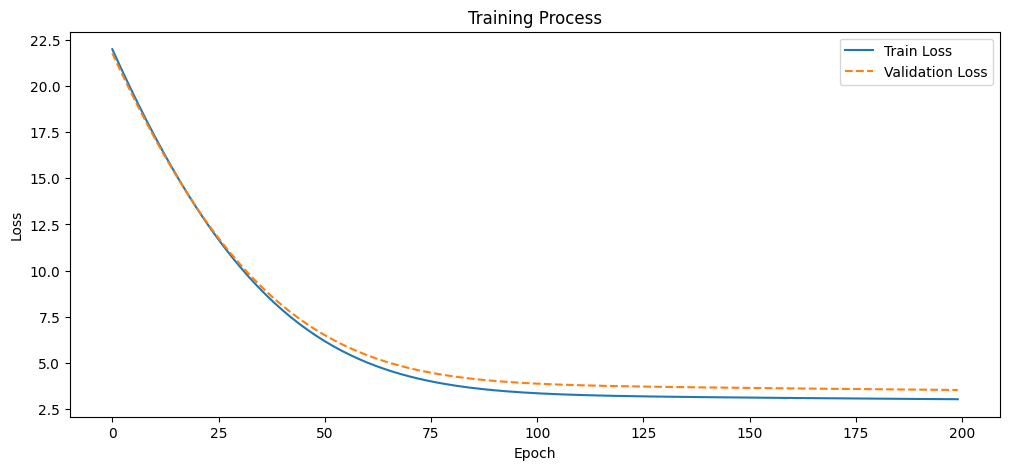

In [19]:
ts = time.time()

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

# ===== Set hyperparameters ===== #
args.in_dim = 2
args.out_dim = 1
args.lr = 0.005
args.epochs = 200 
args.val_interval = 1

list_epoch, list_train_loss, list_val_loss, best_epoch, best_model = model_train(args)


te = time.time()

print('\n Elapsed time: {} sec'.format(int(te-ts)))
print("Best epoch: ", best_epoch)
print("Best validation loss: ", min(list_val_loss))
print("Best model parameters: ")
for name, param in best_model.named_parameters():
    print(name, param.data)

# ====== Visualize the Training Process ====== #
plt.figure(figsize=(12, 5))
plt.plot(list_epoch, list_train_loss, label='Train Loss')
plt.plot(list_epoch, list_val_loss, '--', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Process')
plt.legend()

## 5. Deploy the best model on test


(400, 2) (400,)
(400, 2) (400,)
Test Loss: 1.3631


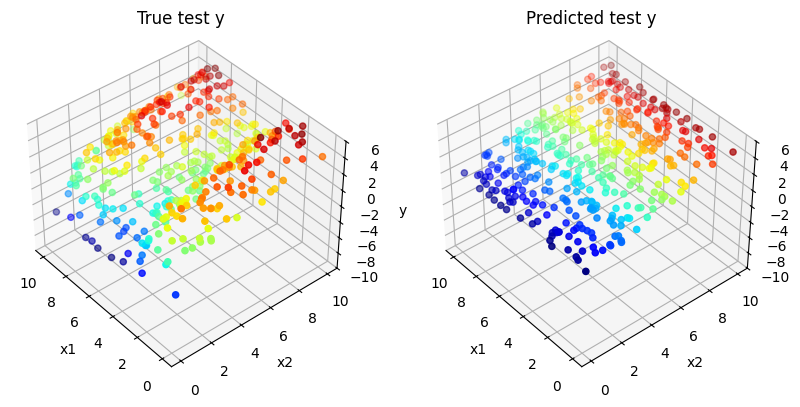

In [28]:
# get the model outputs on test set

test_X_tensor = torch.tensor(test_X, dtype=torch.float32)
test_y_tensor = torch.tensor(test_y, dtype=torch.float32).view(-1, 1)

best_model.eval()
with torch.no_grad():
    test_predictions = best_model(test_X_tensor)
    test_loss = mean_absolute_error(test_y_tensor.numpy(), test_predictions.numpy())
    print(f"Test Loss: {test_loss:.4f}")
    # plot the test set
    fig = plt.figure(figsize=(15,5))

    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    ax1.scatter(test_X[:, 0], test_X[:, 1], test_y, c=test_y, cmap='jet')
    
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x2')
    ax1.set_zlabel('y')
    ax1.set_zlim(-10, 6)
    ax1.view_init(40, -40)
    ax1.set_title('True test y')
    ax1.invert_xaxis()

    # ====== Predicted Y Scattering ====== #
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    ax2.scatter(test_X[:, 0], test_X[:, 1], test_predictions.numpy().squeeze(), c=test_predictions.numpy().squeeze(), cmap='jet')

    ax2.set_xlabel('x1')
    ax2.set_ylabel('x2')
    ax2.set_zlabel('y')
    ax2.set_zlim(-10, 6)
    ax2.view_init(40, -40)
    ax2.set_title('Predicted test y')
    ax2.invert_xaxis()


